# Synchro Project
- [github link](https://github.com/romainmartinez/envergo)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Figures
import matplotlib.pyplot as plt
import seaborn as sns

FIG_STYLE = Path('./fig_style.py')
if not FIG_STYLE.is_file():
    !wget --no-check-certificate --content-disposition https://github.com/romainmartinez/cookbook/raw/master/python/fig_style.py
from fig_style import get_style, show
plt.rcParams.update(get_style(style='mrtnz', figsize='two_col'))

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Get data

In [2]:
DATA_PATH = Path('./data/zTable.xlsx')
df = pd.read_excel(DATA_PATH)

In [3]:
# athletes' name
names = df['name']
# variables
variables = [
    'ADD/G', 'ADD/D', 'ABD/G', 'ABD/D', 'ER/G', 'ER/D', 'IR/G', 'IR/D',
    'EXT/G', 'EXT/D', 'FLEX/G', 'FLEX/D'
]
X = df[variables]
# targets
targets = ['BODYBOOST', 'DYN MAX', 'EGG MAX']
y = df[targets]
# not included: 'DYN SD', 'EGG MIN ', 'EGG SD', 'EGG MAX-MIN'
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,287.05,285.00,206.85,179.90,92.85,94.95,52.3,51.95,166.65,196.70,183.00,146.00
1,292.75,302.75,239.85,207.85,109.25,103.25,98.4,84.05,308.00,257.45,156.60,123.35
2,252.40,258.55,233.45,233.65,69.30,68.80,120.0,119.80,141.10,113.20,199.55,204.80
3,213.45,227.40,174.00,132.10,54.20,56.40,39.9,37.20,138.55,2.00,117.75,112.25
4,281.75,296.20,258.65,227.25,97.25,99.05,77.2,62.45,207.15,166.95,158.50,152.85


### Normalize data
We should normalize the groin bar tests (`X`) by anthropometric measurements.

In [4]:
IMC = df['Weight'] / (df['Height'] * df['Height'])
X = X.divide(IMC, axis=0)

### nan remover

In [5]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "14.005898959881131"
participant no.: 41
	test: IR/G
		"nan" replace by "5.202873000000001"
participant no.: 90
	test: IR/G
		"nan" replace by "5.840712209302325"


### X description
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test




In [6]:
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,16.897022,16.776350,12.176098,10.589703,5.465558,5.589173,3.078607,3.058005,9.809750,11.578625,10.772183,8.594200
1,12.519032,12.946668,10.256840,8.888406,4.671919,4.415338,4.207934,3.594277,13.171177,11.009479,6.696774,5.274885
2,13.443403,13.770966,12.434083,12.444735,3.691077,3.664446,6.391475,6.380823,7.515310,6.029292,10.628491,10.908118
3,11.055767,11.778315,9.012431,6.842196,2.807320,2.921271,2.066644,1.926796,7.176278,0.103591,6.098930,5.814054
4,14.389051,15.127016,13.209327,11.605721,4.966584,5.058511,3.942625,3.189339,10.579208,8.526183,8.094639,7.806092


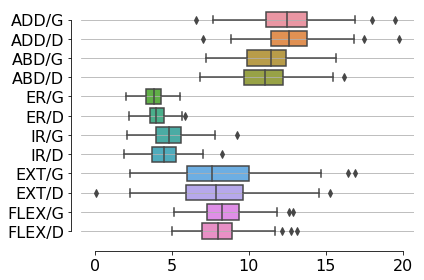

In [7]:
sns.boxplot(data=X, orient='h')
plt.grid(axis='y')
show()

### y description
- `EGG MEAN`: mean eggbeater score
- `EGG MAX`: max. eggbeater score
- `BODYBOOST`: bodyboost score
- `DYN MEAN`: mean dynamometer force
- `DYN MAX`: max. dynamometer force

In [8]:
y.head()

,BODYBOOST,DYN MAX,EGG MAX
0,9.5,8.33,8.5
1,8.5,9.43,7.5
2,8.5,8.76,8.0
3,8.5,9.86,8.0
4,9.0,10.77,7.5


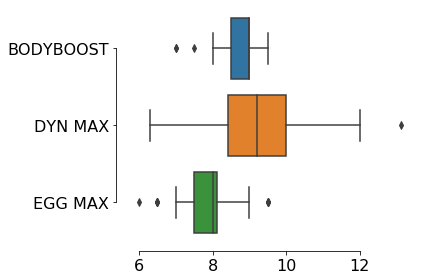

In [9]:
sns.boxplot(data=y, orient='h')
show()

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [10]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance
Let's try to compute the *imbalance* score for each test, such as:
$$\text{imbalance} = |\frac{\text{left} - \text{right}}{\text{left}}| * 100$$

In [11]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [12]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

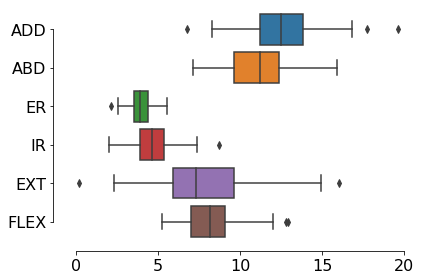

In [13]:
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] != 'i']], orient='h')
show()

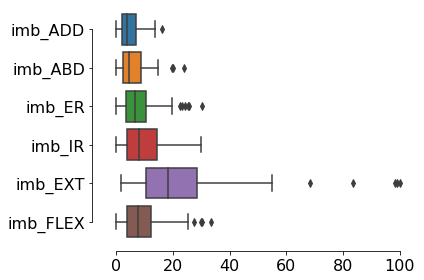

In [14]:
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] == 'i']], orient='h')
sns.despine(offset=10, trim=True)
plt.tight_layout()

## Fitting an ensemble model

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED)

### Helper functions

In [16]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    val = (np.abs((y_test - y_pred) / y_test)) * 100
    return np.mean(val), np.std(val)


def rmse(y_test, y_pred):
    val = np.sqrt(((y_test - y_pred)**2))
    return np.mean(val), np.std(val)


def evaluate(y_test, y_pred):
    d = {}
    d['rmse_mu'], d['rmse_std'] = rmse(y_test, y_pred)
    d['mape_mu'], d['mape_std'] = mape(y_test, y_pred)

    print(f"""
    \trmse = {d['rmse_mu']:.3f} ({d['rmse_std']:.3f})
    \tmape = {d['mape_mu']:.3f}% ({d['mape_std']:.3f})
    """)

    return pd.Series(d)

In [17]:
from skopt import BayesSearchCV, dump, load

class BayesSearch:
    def __init__(self, model, search_spaces, n_iter, export_path):
        self.export_path = export_path
        self.bayes_cv_tuner = BayesSearchCV(
            model,
            search_spaces,
            cv=5,
            n_jobs=-1,
            n_iter=n_iter,
            verbose=0,
            refit=True,
            
            random_state=RANDOM_SEED)

    def fit(self, X, y):
        self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
        self.export_results()

    def print_status(self, optim_results):
        print(f"""
Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
Best: {self.bayes_cv_tuner.best_score_}
Best params: {self.bayes_cv_tuner.best_params_}
        """)

    def export_results(self):
        pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
            f'{self.export_path}_cv_results.csv')
        pd.Series(self.bayes_cv_tuner.best_params_).to_json(
            f'{self.export_path}_best_params.json')
        dump(self.bayes_cv_tuner, f'{self.export_path}_bayes_search.pkl')

/home/romain/miniconda3/envs/synchro/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Optimized model

In [18]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 10

params = {'n_jobs': 1, 'silent': 1, 'tree_method': 'approx'}

if OPT:
    for itarget in targets:
        OPT_EXPORT = f'opt/{itarget}'

        search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'min_child_weight': (0, 10),
            'max_depth': (0, 50),
            'max_delta_step': (0, 20),
            'subsample': (0.01, 1.0, 'uniform'),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'colsample_bylevel': (0.01, 1.0, 'uniform'),
            'reg_lambda': (1e-9, 1000, 'log-uniform'),
            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
            'gamma': (1e-9, 0.5, 'log-uniform'),
            'min_child_weight': (0, 5),
            'n_estimators': (50, 100),
            'scale_pos_weight': (1e-6, 500, 'log-uniform')
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT)
        opt.fit(X_train, y_train[itarget])

In [25]:
USE_OPT = False

boosted = {}
evaluation = pd.DataFrame()

for itarget, itarget_name in enumerate(targets):
    print(itarget, itarget_name)

    if USE_OPT:
        opt_params = load(f'opt/{itarget_name}_bayes_search.pkl').best_params_
    else:
        opt_params = {}

    boosted[itarget_name] = XGBRegressor(
        **{
            **params,
            **opt_params
        }, random_state=RANDOM_SEED)
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test,
                                                     y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric='rmse',
        verbose=10)
    
    evaluation[itarget_name] = evaluate(y_test[itarget_name], boosted[itarget_name].predict(X_test))
    
    print(f'{"-" * 30}\n')

0 BODYBOOST
[0]	validation_0-rmse:7.41009	validation_1-rmse:7.61465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[10]	validation_0-rmse:2.67075	validation_1-rmse:2.89455
[20]	validation_0-rmse:1.04557	validation_1-rmse:1.32916
[30]	validation_0-rmse:0.497723	validation_1-rmse:0.787674
[40]	validation_0-rmse:0.301706	validation_1-rmse:0.643858
[50]	validation_0-rmse:0.224712	validation_1-rmse:0.605683
[60]	validation_0-rmse:0.177135	validation_1-rmse:0.591934
[70]	validation_0-rmse:0.145841	validation_1-rmse:0.589574
[80]	validation_0-rmse:0.119046	validation_1-rmse:0.591809
[90]	validation_0-rmse:0.094999	validation_1-rmse:0.593206
[99]	validation_0-rmse:0.080096	validation_1-rmse:0.600134

    	rmse = 0.493 (0.342)
    	mape = 5.570% (3.996)
    
------------------------------

1 DYN MAX
[0]	validation_0-rmse:7.92903	validation_1-rmse:8.27114
Multiple eval metrics have bee

## Interpretation

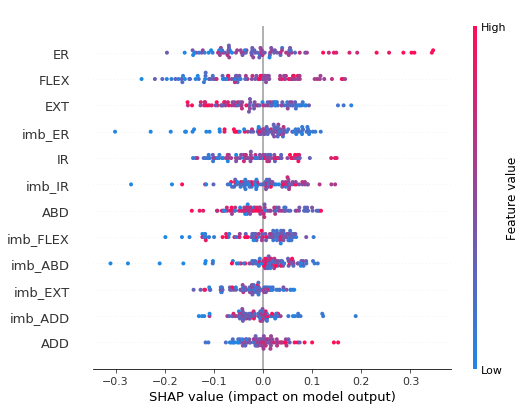

In [25]:
import shap
shap.initjs()
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(opt_boosted)
shap_values = explainer.shap_values(X_augmented)
shap.summary_plot(shap_values, X_augmented)

## Evaluation